Реализовать оценку Out-of-Bag ошибок для каждого из деревьев леса

____

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mode
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Times New Roman'


In [3]:
from collections import Counter

In [4]:
from my_metrics import metrics, get_full_report

____

In [5]:
class RFClassifier:

    def __init__(self, max_features=None, n_trees=2, min_leaf=1, max_depth=np.inf, inf_value_type="Gini"):
        self.n_trees = n_trees
        self.min_leaf = min_leaf
        self.inf_value_type = inf_value_type
        self.max_depth = max_depth
        self.max_features = max_features

#         self.node_dict = {}
#         self.leaf_list = []
#         self.level = 0
#         self.prediction_mask = {}
        self.prediction = None
        self.y_proba = None
        self.proba_data = None
        self.forest_pred = []
        self.forest_proba = []
        self.oob = []

    @staticmethod
    def get_label_num(y_list):
        num = Counter(y_list)
        return dict(num)

    def get_bootstrap_idx(self, n_samples):
        indexes = np.random.randint(0, n_samples-1, size=n_samples)
        return indexes

    def get_subsample(self, n_features):

        if self.max_features is None:
            self.max_features = int(np.sqrt(n_features))
        subsample = np.random.choice(
            n_features, self.max_features, replace=False)

        return subsample

    def get_informative_value(self, y_list):
        labels_dict = self.get_label_num(y_list)

        if self.inf_value_type == "Gini":
            impurity = 1
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                impurity -= p_label**2
            return impurity

        if self.inf_value_type == "Shannon":
            entropy = 0
            for label in labels_dict:
                p_label = labels_dict[label] / len(y_list)
                entropy -= p_label * (0 if (p_label == 0)
                                      else np.log2(p_label))
            return entropy

    def merit_functional(self, true_labels, false_labels, current_informative_value):

        p = (true_labels.shape[0]) / \
             ((true_labels.shape[0]) + (false_labels.shape[0]))
        quality = current_informative_value - p * \
            self.get_informative_value(true_labels) - (1 - p) * \
            self.get_informative_value(false_labels)
        return quality

    def find_best_split(self, X, y):

        current_informative_value = self.get_informative_value(y)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]
        subsample = self.get_subsample(n_features)

        for index in subsample:
            t_values = set(X[:, index])

            for t in t_values:
                true_data, false_data, true_labels, false_labels = self.data_split(
                    X, y, index, t)
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue

                current_quality = self.merit_functional(
                    true_labels, false_labels, current_informative_value)

                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def data_split(self, X, y, feature_idx, t):

        left = (X[:, feature_idx] <= t)

        true_data = X[left]
        false_data = X[~left]
        true_labels = y[left]
        false_labels = y[~left]
        return true_data, false_data, true_labels, false_labels

    def tree_fit(self, X, y):
        self.leaf_list = []
        self.prediction_mask = {}
        self.node_dict = {}
        self.level = 0
        data_id = 0
        data_list = []
        data_list.append([X, y, None, None, data_id])
        tree_params = []
        next_level_data = []
        fl = 0
        mask = []

        while not fl:
            if self.level > 0:
                data_list.clear()
                data_list = next_level_data.copy()
                next_level_data.clear()

            for data in data_list:

                best_quality, best_t, best_index = self.find_best_split(
                    data[0], data[1])
                if best_quality and (self.level <= self.max_depth):
                    true_data, false_data, true_labels, false_labels = self.data_split(
                        data[0], data[1], best_index, best_t)
                    self.node_dict[data[4]] = [
                        data[2], data[3], best_index, best_t]
                    data_id += 1
                    next_level_data.append(
                        [true_data, true_labels, True, data[4], data_id])
                    data_id += 1
                    next_level_data.append(
                        [false_data, false_labels, False, data[4], data_id])
                else:
                    leaf = self.get_label_num(data[1])
                    prediction = max(leaf, key=leaf.get)
                    proba = leaf[prediction] / len(data[0])
                    if prediction == 0:
                        proba = 1 - proba
                    self.leaf_list.append(
                        [data[2], data[3], proba, prediction])

                self.level += 1

            if (next_level_data == []):
                fl = 1

        for leaf in self.leaf_list:
            mask = [(leaf[0], leaf[1])]
            next_step = leaf[1]

            while True:

                if next_step is not None and next_step != 0:
                    mask.append(
                        (self.node_dict[next_step][0], self.node_dict[next_step][1]))
                    next_step = self.node_dict[next_step][1]
                else:
                    mask.reverse()
                    self.prediction_mask[tuple(mask)] = leaf[2], leaf[3]
                    break

    def tree_predict(self, X):

        y_pred_proba_list = [None for i in range(len(X))]

        for mask in self.prediction_mask:
            answer_mask = []
            predict_mask = [mask[i][0] for i in range(len(mask))]

            for question in mask:
                idx = self.node_dict[question[1]][2]
                t = self.node_dict[question[1]][3]
                y_pred_proba = [self.prediction_mask[mask]]
                answer_mask.append(X[:, idx] <= t)
                answer_mask_array = np.array(answer_mask).T.tolist()

            for num, answer in enumerate(answer_mask_array):
                if answer == predict_mask and y_pred_proba_list[num] is None:
                    y_pred_proba_list[num] = y_pred_proba

        self.prediction = np.array(y_pred_proba_list).reshape(-1, 2)[:, 1]
        self.y_proba = np.array(y_pred_proba_list).reshape(-1, 2)[:, 0]

        return self.prediction, self.y_proba

    def fit_predict(self, X, y, X_test, oob_score=True, oob_vote:float=None):
        
        forest_pred = []
        forest_proba = []
        n_samples = X.shape[0]
        for tree in range(self.n_trees):
            
            idx = self.get_bootstrap_idx(n_samples)
            self.tree_fit(X[idx,:], y[idx])
            pred, proba = self.tree_predict(X_test)
            forest_proba.append(proba)
            forest_pred.append(pred)
            if oob_score:
                oob_idx = list(set(range(n_samples)).difference(idx))
                oob_pred, _ = self.tree_predict(X[oob_idx,:])
                oob_tree_score = metrics(y[oob_idx], oob_pred, metric='accuracy')
                self.oob.append(oob_tree_score)

        self.forest_pred = np.array(forest_pred).T.reshape(X_test.shape[0], -1)
        self.forest_proba = np.array(forest_proba).T.reshape(X_test.shape[0], -1)

        if oob_vote:
            vote_mask = (self.oob >= np.quantile(self.oob, oob_vote))
            self.forest_proba = np.delete(self.forest_proba, vote_mask, axis=1)
            self.forest_pred = np.delete(self.forest_pred, vote_mask, axis=1)
        

        return mode(self.forest_pred, axis=1)[0].flatten(), np.mean(self.forest_proba, axis=1)

*******

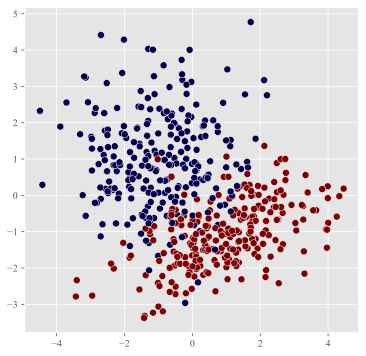

In [6]:
# сгенерируем данные
from sklearn import datasets
from sklearn import model_selection

X, y = datasets.make_classification(n_samples=500,
                                    n_features=5, n_informative=5,
                                    n_classes=2, n_redundant=0,
                                    n_clusters_per_class=1, random_state=13)


plt.figure(figsize=(6, 6))
plt.scatter(list(map(lambda x: x[0], X)), list(map(lambda x: x[1], X)),
            c=y, cmap='seismic', edgecolors="white", s=50)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size=0.3,
                                                                    random_state=1)

In [7]:
# проверка работы случайного леса при 3, 5, 10, 20, 50, 100 деревьях:

for trees in [3, 5, 10, 20, 50, 100]:

    rf_model = RFClassifier(n_trees=trees)
    y_pred, y_proba = rf_model.fit_predict(X_train, y_train, X_test)
    title = f'Случайный лес из {trees} деревьев. Тестовая выборка'
    get_full_report(y_test, y_pred, y_proba, title=title)

Случайный лес из 3 деревьев. Тестовая выборка. Метрика accuracy = 0.88
Случайный лес из 3 деревьев. Тестовая выборка. Метрика f1_score = 0.8816
Случайный лес из 3 деревьев. Тестовая выборка. Метрика precision_recall = (0.859, 0.9054)

Случайный лес из 5 деревьев. Тестовая выборка. Метрика accuracy = 0.8867
Случайный лес из 5 деревьев. Тестовая выборка. Метрика f1_score = 0.8917
Случайный лес из 5 деревьев. Тестовая выборка. Метрика precision_recall = (0.8434, 0.9459)

Случайный лес из 10 деревьев. Тестовая выборка. Метрика accuracy = 0.9267
Случайный лес из 10 деревьев. Тестовая выборка. Метрика f1_score = 0.929
Случайный лес из 10 деревьев. Тестовая выборка. Метрика precision_recall = (0.8889, 0.973)

Случайный лес из 20 деревьев. Тестовая выборка. Метрика accuracy = 0.9267
Случайный лес из 20 деревьев. Тестовая выборка. Метрика f1_score = 0.9281
Случайный лес из 20 деревьев. Тестовая выборка. Метрика precision_recall = (0.8987, 0.9595)

Случайный лес из 50 деревьев. Тестовая выборка.

In [16]:
# проверим работу Random Forest на 20 деревьях.
# При этом в глосовании учавствуют деревья с лучшими показателями oob_accuracy (>= quantile 0.5)

rf_model = RFClassifier(n_trees=20)
y_pred, y_proba = rf_model.fit_predict(X_train, y_train, X_test, oob_vote=0.5)
title = f'Случайный лес из {trees} деревьев. Тестовая выборка'
get_full_report(y_test, y_pred, y_proba, title=title)

Случайный лес из 100 деревьев. Тестовая выборка. Метрика accuracy = 0.9533
Случайный лес из 100 деревьев. Тестовая выборка. Метрика f1_score = 0.9536
Случайный лес из 100 деревьев. Тестовая выборка. Метрика precision_recall = (0.9351, 0.973)



In [19]:
np.mean(rf_model.oob)

0.8874600000000001